# Importing Modules

In [1]:
# Data Handling
import pandas as pd
import numpy as np
 
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from geopy.distance import geodesic

# Sampling & Scaling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import pickle

# Warning Handling
import warnings
warnings.simplefilter("ignore")

# Defining Functions for Accuracy Metrics, Distance Calculation & Modelling

In [2]:
def mean_absolute_percentage_error(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def acc_metrics(actual_values,predicted_values):
    print('Accuracy Metrics:')
    mse=round(mean_squared_error(actual_values,predicted_values),2)
    rmse=round(sqrt(mse),2)
    mape=round(mean_absolute_percentage_error(actual_values,predicted_values),2)    
    print('Mean Squared Error: ',mse)
    print('Root Mean Squared Error: ',rmse)
    print('Mean Absolute Percentage Error: ',mape)
           
    return mse,rmse,mape

In [3]:
def modelling(x_train, x_test, y_train, y_test):
    
    print('\nLinear Regression Modelling')
    LR_model=LinearRegression()
    LR_model.fit(x_train,y_train)
    acc_metrics(y_test,LR_model.predict(x_test))
    
    print('\nDecision Tree Regressor Modelling')
    DT_model=DecisionTreeRegressor(max_depth=5)
    DT_model.fit(x_train,y_train)
    acc_metrics(y_test,DT_model.predict(x_test))
    
    print('\nRandom Forest Regressor Modelling')
    RF_model=RandomForestRegressor()
    RF_model.fit(x_train,y_train)
    acc_metrics(y_test,RF_model.predict(x_test))
    
    print('\nLightGBM Regressor Modelling')
    LGB_model = LGBMRegressor()
    LGB_model.fit(x_train, y_train, eval_set=[(x_test,y_test)],eval_metric='rmse', verbose=0, early_stopping_rounds=5000)
    acc_metrics(y_test,LGB_model.predict(x_test))
    
    return LR_model, DT_model, RF_model, LGB_model

In [4]:
def distance(dataset):
    geodesic_dist=[]
    
    for i in range(len(dataset)):
        pickup = (dataset.pickup_latitude.iloc[i], dataset.pickup_longitude.iloc[i])
        dropoff = (dataset.dropoff_latitude.iloc[i], dataset.dropoff_longitude.iloc[i])
        geodesic_dist.append(abs(round(geodesic(pickup, dropoff).miles,2)))
        
    dataset['distance']=geodesic_dist
    dataset.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],inplace=True)

    return dataset

In [5]:
def time_features(dataset):
    dataset['year']=pd.DatetimeIndex(dataset.pickup_datetime).year
    dataset['month']=pd.DatetimeIndex(dataset.pickup_datetime).month
    dataset['week_day']=pd.DatetimeIndex(dataset.pickup_datetime).weekday
    dataset['hour']=pd.DatetimeIndex(dataset.pickup_datetime).hour
       
    dataset.drop(columns=['pickup_datetime'],inplace=True)
    
    return dataset    

In [6]:
def cab_type(dataset):
    dataset['cab_type']=[0 if i<4 else 1 for i in dataset.passenger_count ]
    dataset.drop(columns=['passenger_count'],inplace=True)
    
    return dataset

# Importing Datasets

In [7]:
train_data=pd.read_csv('train_cab.csv')
test_data=pd.read_csv('test.csv')

In [8]:
train_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [9]:
test_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [10]:
train_data["fare_amount"] = pd.to_numeric(train_data["fare_amount"],errors = "coerce")
train_data.pickup_datetime=pd.to_datetime(train_data.pickup_datetime,errors='coerce')

test_data.pickup_datetime=pd.to_datetime(test_data.pickup_datetime,errors='coerce')

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        16042 non-null  float64            
 1   pickup_datetime    16066 non-null  datetime64[ns, UTC]
 2   pickup_longitude   16067 non-null  float64            
 3   pickup_latitude    16067 non-null  float64            
 4   dropoff_longitude  16067 non-null  float64            
 5   dropoff_latitude   16067 non-null  float64            
 6   passenger_count    16012 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.8 KB


In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 1   pickup_longitude   9914 non-null   float64            
 2   pickup_latitude    9914 non-null   float64            
 3   dropoff_longitude  9914 non-null   float64            
 4   dropoff_latitude   9914 non-null   float64            
 5   passenger_count    9914 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [13]:
train_data.shape

(16067, 7)

In [14]:
test_data.shape

(9914, 6)

##### Observations for datasets:
1. The train data contains 16067 observations.
2. The test data contains 9914 observations.
3. Train Data contains a datetime variable, a passanger count variable, pickup & dropoff Latitute longitude variables & one
   target variable fare amount.
4. Test Data contains a datetime variable, a passanger count variable & pickup & dropoff Latitute longitude variables.

# Data Pre-Processing

### 1. Missing Value Analysis

In [15]:
train_data.isnull().sum().sum()

81

In [16]:
test_data.isnull().sum().sum()

0

In [17]:
# Missing Values in Train Data

train_data.isnull().sum()

fare_amount          25
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [18]:
# Dropping the missing values

train_data.dropna(inplace=True)

In [19]:
train_data.shape

(15986, 7)

In [20]:
test_data.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

##### Observations missing value analysis:
1. The train dataset contains 81 missing values. Which is 0.5% of total observations, thus dropping missing values.
2. The test dataset doesnot contains any missing values.
3. Shape of train dataset after removing missing values is: (15986, 7)

### 2. Checking training data for impurities

In [21]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000
mean,15.030453,-72.464352,39.915577,-72.463909,39.898671,2.623272
std,431.213944,10.573594,6.829028,10.570256,6.186375,60.892140
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992144,40.734935,-73.991182,40.734647,1.000000
50%,8.500000,-73.981691,40.752603,-73.980168,40.753549,1.000000
75%,12.500000,-73.966817,40.767353,-73.963644,40.768005,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [22]:
test_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


##### Observations for train data:
1. This data is for United States as lat 40.xxx & long -73.xxx locate to New York United States. So, 
    latitude range  = 40.xxx to 42.xxx
    longitude range = -72.xxx to -74.xxx
2. Impure data in pickup & dropoff longitude as it contains values outside their range i.e. 40.xxx.
3. Impure data in pickup & dropoff latitude as it contains values outside their range i.e. -74.xxx.
4. Fare Amount contains some very high values as Standard deviation of $ 430 is quite high. 

### 3. Treating training data for impurities

#### A. Treating Passenger Count

In [23]:
test_data.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

In [24]:
train_data.passenger_count=train_data.passenger_count.astype('int')
train_data.passenger_count.unique()

array([   1,    2,    3,    6,    5,    4,  236,  456, 5334,    0,  535,
        354,  554,   53,   35,  345, 5345,  536,   43,   58,  537,   87,
        531,  557])

In [25]:
#As Test data contains the values in range [1,2,3,4,5,6]. Removing all the other values from dataset.

i=[1,2,3,4,5,6]
train_data.passenger_count=train_data.passenger_count.transform(lambda x: None if (x not in i) else x )

In [26]:
train_data.passenger_count.value_counts()

1.0    11242
2.0     2319
5.0     1044
3.0      675
4.0      328
6.0      301
Name: passenger_count, dtype: int64

In [27]:
train_data.dropna(inplace=True)

In [28]:
train_data.passenger_count=train_data.passenger_count.astype('int')

In [29]:
train_data.shape

(15909, 7)

#### B. Treating Fare Amount

(array([2., 1., 0., 0., 0., 0., 0., 2., 0., 1.]),
 array([-3.   , -2.586, -2.172, -1.758, -1.344, -0.93 , -0.516, -0.102,
         0.312,  0.726,  1.14 ]),
 <a list of 10 Patch objects>)

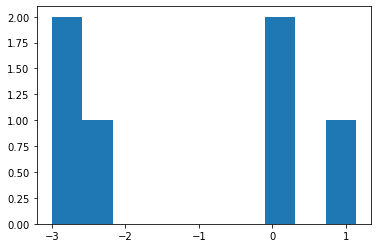

In [30]:
# Taking he minimum value of fare_amount as $2.5

plt.hist(train_data.fare_amount[train_data.fare_amount<2.5])

In [31]:
#Treating All the values less then $2.5 with None & removing them

train_data.fare_amount[train_data.fare_amount <2.5]=None

In [32]:
train_data.dropna(inplace=True)

In [33]:
train_data.shape

(15903, 7)

#### C. Treating Pickup & dropoff (Lat Long) Values

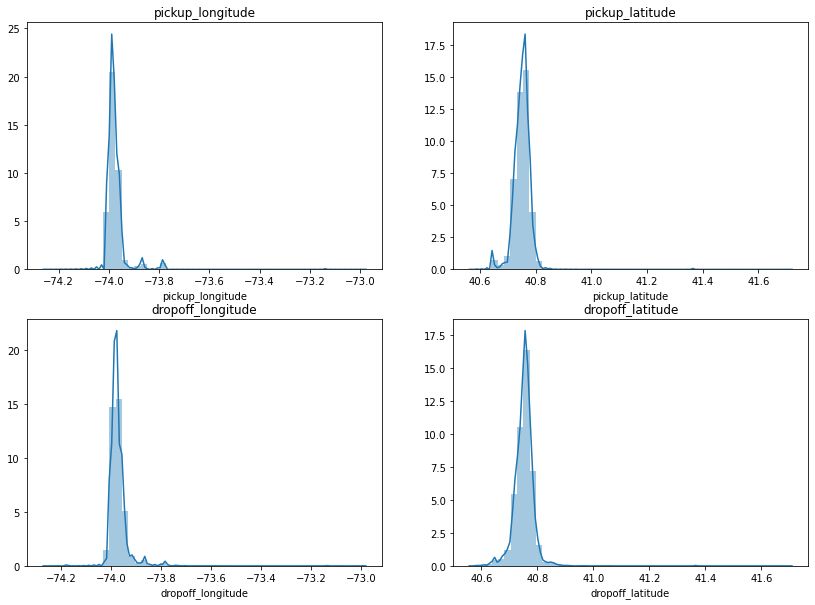

In [34]:
plt.figure(figsize=(14,10))
for i,col in enumerate(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']):
    plt.subplot(2,2,i+1)
    sns.distplot(test_data[col])
    plt.title(col)
plt.show()    

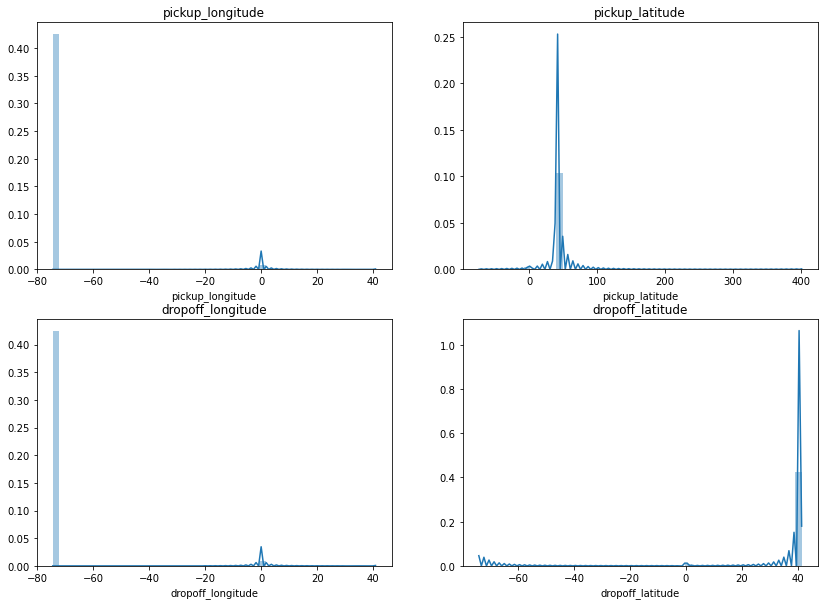

In [35]:
plt.figure(figsize=(14,10))
for i,col in enumerate(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']):
    plt.subplot(2,2,i+1)
    sns.distplot(train_data[col])
    plt.title(col)
plt.show()    

In [36]:
# lat long values Treating All the values outside range with None

train_data.dropoff_latitude[train_data.dropoff_latitude < 40] = None
train_data.dropoff_latitude[train_data.dropoff_latitude > 42] = None

train_data.pickup_latitude[train_data.pickup_latitude < 40] = None
train_data.pickup_latitude[train_data.pickup_latitude > 42] = None

train_data.dropoff_longitude[train_data.dropoff_longitude < -74] = None
train_data.dropoff_longitude[train_data.dropoff_longitude > -72] = None

train_data.pickup_longitude[train_data.pickup_longitude < -74] = None
train_data.pickup_longitude[train_data.pickup_longitude > -72] = None

In [37]:
train_data.dropna(inplace=True)

In [38]:
train_data.shape

(12034, 7)

In [39]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,11.059156,-73.968718,40.755722,-73.967540,40.756736,1.640435
std,10.265631,0.042519,0.032423,0.039460,0.034069,1.257543
min,2.500000,-73.999998,40.121653,-73.999999,40.164927,1.000000
25%,5.700000,-73.987535,40.743621,-73.986256,40.744209,1.000000
50%,8.100000,-73.978250,40.758355,-73.976810,40.758629,1.000000
75%,12.000000,-73.963726,40.771040,-73.961000,40.772251,2.000000
max,434.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000


### 4. Outlier Analysis on fare_amount

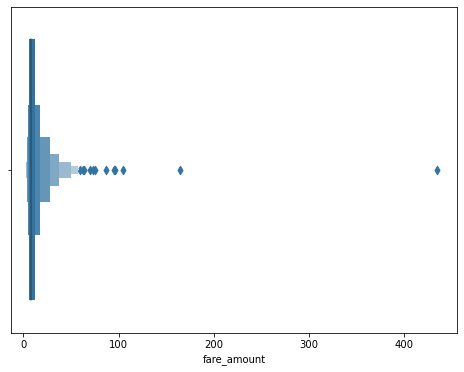

In [40]:
plt.figure(figsize=(8,6))
sns.boxenplot(train_data.fare_amount)

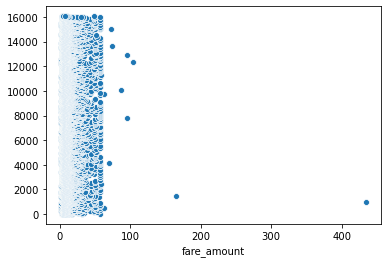

In [41]:
sns.scatterplot(train_data.fare_amount,train_data.index)

In [42]:
# Fare Amount Column

q75, q25 = np.percentile(train_data.fare_amount, [75 ,25])
iqr = q75 - q25
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)

train_data.fare_amount[train_data.fare_amount < minimum]=None
train_data.fare_amount[train_data.fare_amount > maximum]=None

print('Max out bound: ',maximum)
print('Min out bound: ',minimum)

Max out bound:  21.45
Min out bound:  -3.749999999999999


In [43]:
train_data.dropna(inplace=True)
train_data.shape

(10904, 7)

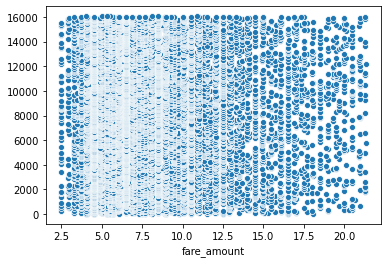

In [44]:
sns.scatterplot(train_data.fare_amount,train_data.index)

In [45]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10904.000000,10904.000000,10904.000000,10904.000000,10904.000000,10904.000000
mean,8.478238,-73.973953,40.757525,-73.972399,40.757868,1.634079
std,3.835843,0.032338,0.029588,0.030854,0.030208,1.255565
min,2.500000,-73.999998,40.121653,-73.999999,40.164927,1.000000
25%,5.500000,-73.987781,40.744323,-73.986828,40.745075,1.000000
50%,7.500000,-73.978776,40.758517,-73.977677,40.758728,1.000000
75%,10.500000,-73.965827,40.771043,-73.963447,40.772084,2.000000
max,21.330000,-73.137393,41.366138,-73.137393,41.366138,6.000000


# Exploratory Data Analysis & Visualizations

### 1. Feature Engineering

#### A. Creating distance feature

In [46]:
train_data=distance(train_data)
test_data=distance(test_data)

In [47]:
train_data.distance.value_counts()

0.00    153
0.76     84
0.72     81
0.54     76
0.60     75
       ... 
5.34      1
6.07      1
4.72      1
4.86      1
6.39      1
Name: distance, Length: 586, dtype: int64

In [48]:
test_data.distance.value_counts()

0.00    90
0.66    68
0.85    65
0.98    61
0.53    60
        ..
6.86     1
4.98     1
6.82     1
8.38     1
6.39     1
Name: distance, Length: 961, dtype: int64

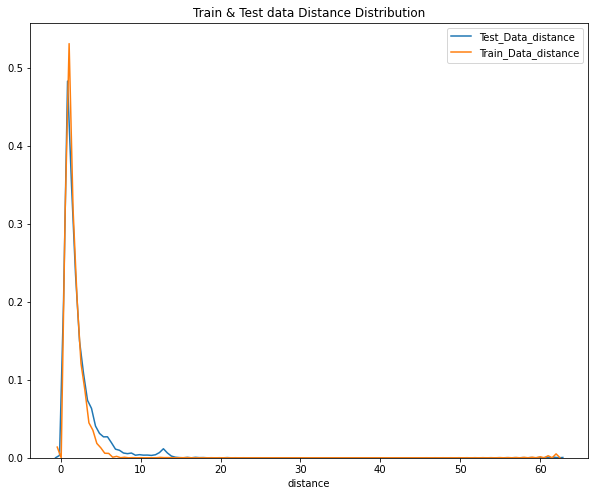

In [49]:
plt.figure(figsize=(10,8))

sns.distplot(test_data['distance'],label='Test_Data_distance', hist=False)
plt.title('test_data')
sns.distplot(train_data['distance'],label='Train_Data_distance', hist=False)
plt.title('train_data')
plt.title("Train & Test data Distance Distribution")
plt.legend()
plt.show()  

##### Observations from above: 
1. Train & Test data almost have same distance distribution. Most Values lies between 0 - 10.
2. Distance contains zero values.

In [50]:
train_data.distance=train_data.distance.transform(lambda x: None if ((x == 0) or (x > 10)) else x )
train_data.dropna(inplace=True)

In [51]:
train_data.shape

(10738, 4)

In [52]:
train_data.describe()

,fare_amount,passenger_count,distance
count,10738.000000,10738.000000,10738.000000
mean,8.508196,1.636059,1.449665
std,3.834311,1.257546,1.037355
min,2.500000,1.000000,0.010000
25%,5.700000,1.000000,0.720000
50%,7.700000,1.000000,1.160000
75%,10.500000,2.000000,1.870000
max,21.330000,6.000000,8.420000


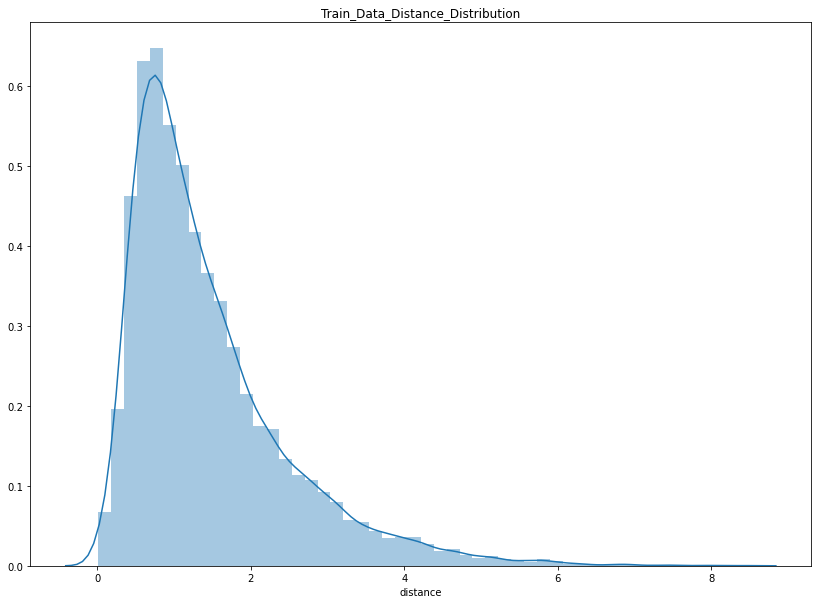

In [53]:
plt.figure(figsize=(14,10))
sns.distplot(train_data['distance'])
plt.title('Train_Data_Distance_Distribution')
plt.show()  

In [54]:
train_data.head()

,fare_amount,pickup_datetime,passenger_count,distance
0,4.5,2009-06-15 17:26:21+00:00,1,0.64
2,5.7,2011-08-18 00:35:00+00:00,2,0.86
3,7.7,2012-04-21 04:30:42+00:00,1,1.74
4,5.3,2010-03-09 07:51:00+00:00,1,1.24
6,7.5,2012-11-20 20:35:00+00:00,1,0.97


#### B. Creating Timestamp based feature

In [55]:
train_data=time_features(train_data)
test_data=time_features(test_data)

In [56]:
train_data.head()

,fare_amount,passenger_count,distance,year,month,week_day,hour
0,4.5,1,0.64,2009,6,0,17
2,5.7,2,0.86,2011,8,3,0
3,7.7,1,1.74,2012,4,5,4
4,5.3,1,1.24,2010,3,1,7
6,7.5,1,0.97,2012,11,1,20


#### C. Creating Passenger Count based feature

In [57]:
# 0 for small cab  &  1 for large cab

train_data=cab_type(train_data)
test_data=cab_type(test_data)

In [58]:
train_data.head()

,fare_amount,distance,year,month,week_day,hour,cab_type
0,4.5,0.64,2009,6,0,17,0
2,5.7,0.86,2011,8,3,0,0
3,7.7,1.74,2012,4,5,4,0
4,5.3,1.24,2010,3,1,7,0
6,7.5,0.97,2012,11,1,20,0


In [59]:
test_data.head()

,distance,year,month,week_day,hour,cab_type
0,1.44,2015,1,1,13,0
1,1.51,2015,1,1,13,0
2,0.38,2011,10,5,11,0
3,1.22,2012,12,5,21,0
4,3.34,2012,12,5,21,0


### 2. Visualizing the effects of feature's on target variable

#### A. Hour effect on no of rides

Text(0.5, 1.0, 'Hour_No_Of_Rides_Distribution')

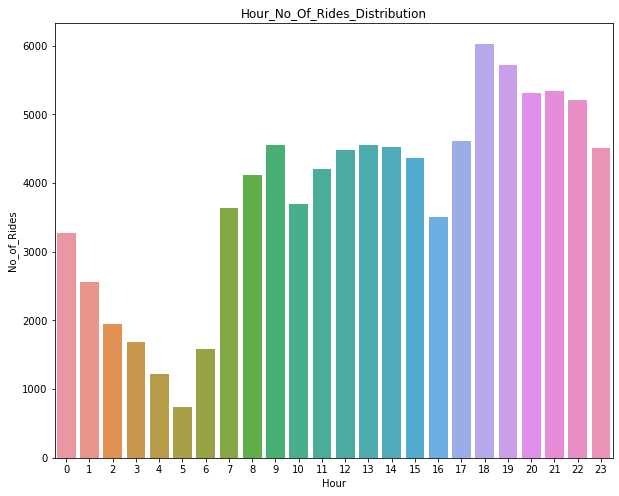

In [60]:
plt.figure(figsize=(10,8))
hour_fare=train_data.groupby(by='hour').fare_amount.sum()
sns.barplot(hour_fare.index,hour_fare)
plt.ylabel('No_of_Rides')
plt.xlabel('Hour')
plt.title('Hour_No_Of_Rides_Distribution')

##### Observations from above: 
1.	6.00 PM – 11.00 PM hours shows higher number of cab rides.
2.	1.00 AM – 6.00 AM hours shows lower number of cab rides.


#### B. Hour effect on Fare Amount

Text(0.5, 1.0, 'Hour_FareAmount_Distribution')

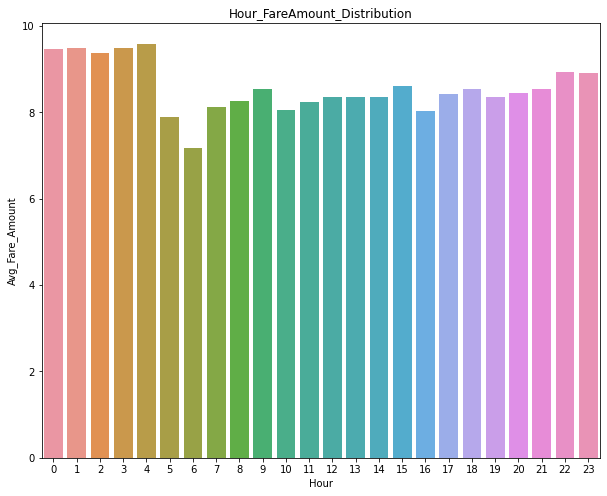

In [61]:
# Hour effect on fare_amount
plt.figure(figsize=(10,8))
hour_fare=train_data.groupby(by='hour').fare_amount.mean()
sns.barplot(hour_fare.index,hour_fare)
plt.ylabel('Avg_Fare_Amount')
plt.xlabel('Hour')
plt.title('Hour_FareAmount_Distribution')

##### Observations from above: 
Late night hours 10.00 PM – 4.00 AM shows higher fare rates.


#### C. Week Day effect on Fare Amount

Text(0.5, 1.0, 'WeekDay_FareAmount_Distribution')

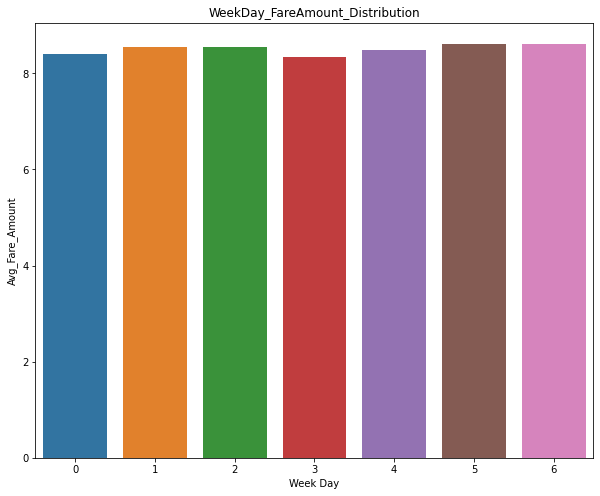

In [62]:
plt.figure(figsize=(10,8))
week_day_fare=train_data.groupby(by='week_day').fare_amount.mean()
sns.barplot(week_day_fare.index,week_day_fare)
plt.ylabel('Avg_Fare_Amount')
plt.xlabel('Week Day')
plt.title('WeekDay_FareAmount_Distribution')

##### Observations from above: 
Weekday shows no major impact on fare_amount.


#### D. Month effect on Fare Amount

Text(0.5, 1.0, 'Month_FareAmount_Distribution')

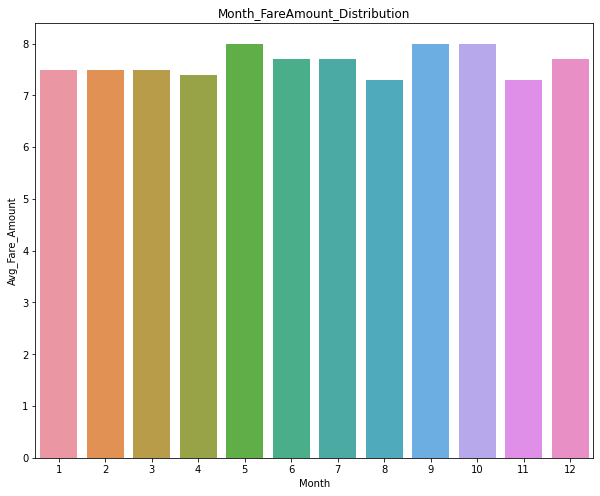

In [63]:
plt.figure(figsize=(10,8))
month_fare=train_data.groupby(by='month').fare_amount.median()
sns.barplot(month_fare.index,month_fare)
plt.ylabel('Avg_Fare_Amount')
plt.xlabel('Month')
plt.title('Month_FareAmount_Distribution')

##### Observations from above: 
Month shows no major impact on fare_amount.


#### E. Year effect on Fare Amount

Text(0.5, 1.0, 'Year_FareAmount_Distribution')

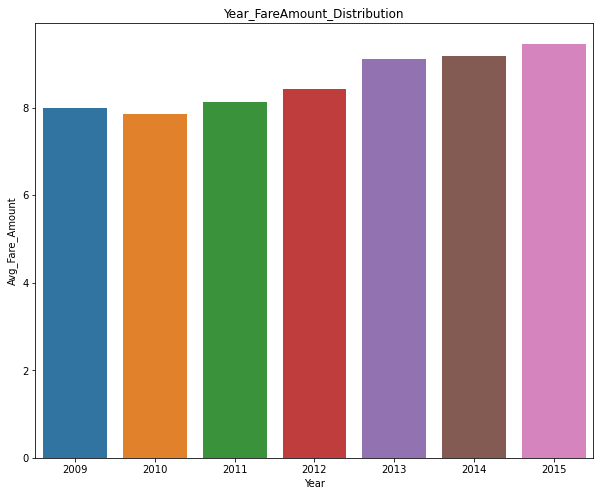

In [64]:
plt.figure(figsize=(10,8))
year_fare=train_data.groupby(by='year').fare_amount.mean()
sns.barplot(year_fare.index,year_fare)
plt.ylabel('Avg_Fare_Amount')
plt.xlabel('Year')
plt.title('Year_FareAmount_Distribution')

##### Observations from above: 
Year shows a slight increasing effect on Fare Amount.


#### F. Distance effect on Fare Amount

Text(0.5, 1.0, 'Distance_Fare_Amount_Distribution')

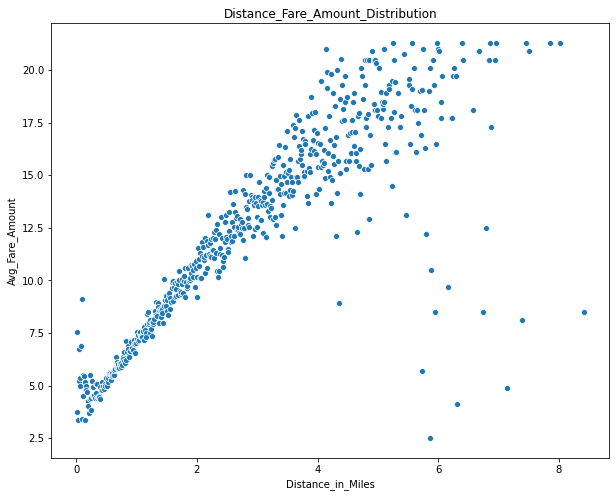

In [65]:
plt.figure(figsize=(10,8))
distance_fare=train_data.groupby(by='distance').fare_amount.mean()
sns.scatterplot(distance_fare.index,distance_fare)
plt.ylabel('Avg_Fare_Amount')
plt.xlabel('Distance_in_Miles')
plt.title('Distance_Fare_Amount_Distribution')

##### Observations from above: 
Distance shows a highly linear increasing effect on Fare Amount.


#### G. Cab Type effect on Number of Rides

In [66]:
cab_type_fare=pd.DataFrame(train_data.groupby(by='cab_type').fare_amount.sum())
cab_type_fare

,fare_amount
cab_type,
0,81902.18
1,9458.83


<Figure size 864x720 with 0 Axes>

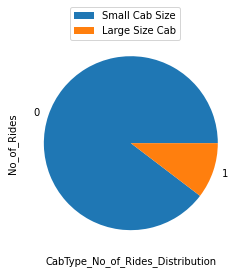

In [67]:
plt.figure(figsize=(12,10))
cab_type_fare.plot.pie(y='fare_amount')
plt.ylabel('No_of_Rides')
plt.xlabel('CabType_No_of_Rides_Distribution')
label={0:'Small Cab Size',1:'Large Size Cab'}
plt.legend(["Small Cab Size", "Large Size Cab"],bbox_to_anchor =(0.75, 1.15))

##### Observations from above: 
Most of the cabs rides are of small size cab.


### 3. Feature Selection

#### A. Features Multi Collinearity Test

Text(0.5, 1.0, 'Features_Inter_Correlation_Plot')

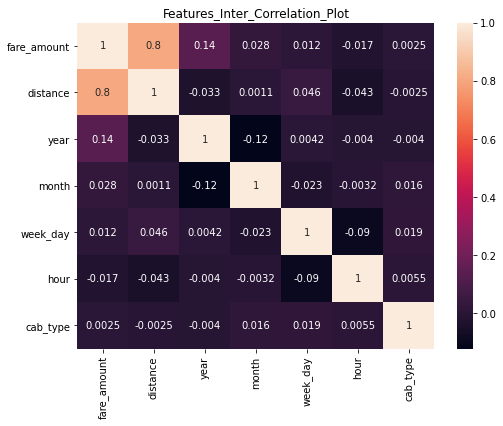

In [68]:
plt.figure(figsize=(8,6))
corr=train_data.corr()
sns.heatmap(corr,annot=True)
plt.title('Features_Inter_Correlation_Plot')

#### B. Categorical Features - Target Chi Square Test

In [69]:
#performing Chi square Test
'''
Significance level: 0.5

Alternate Hypothesis: Column and fare_amount have linear Relationship.        pValue <= 0.5 

Null Hypothesis:Column and fare_amount doesn't have linear Relationship.      pValue > 0.5 
'''
from scipy.stats import chi2_contingency
cat_cols=train_data.drop(columns=['fare_amount','distance']).columns
col_reduced=[]
for i in cat_cols:
    ct = pd.crosstab(train_data[i],train_data['fare_amount'])
    stat,pvalue,dof,expected_R = chi2_contingency(ct)

    if pvalue <= 0.05:
        print("Alternate Hypothesis passed.",i," and fare_amount have linear Relationship. Stat Value: ",stat)
    else:
        col_reduced.append(i)
        print("Fail to Reject Null Hypothesis.",i," and fare_amount doesn't have linear Relationship. Stat Value: ",stat) 

Alternate Hypothesis passed. year  and fare_amount have linear Relationship. Stat Value:  8012.770514321917
Alternate Hypothesis passed. month  and fare_amount have linear Relationship. Stat Value:  1554.1134100596967
Fail to Reject Null Hypothesis. week_day  and fare_amount doesn't have linear Relationship. Stat Value:  753.9326897507752
Alternate Hypothesis passed. hour  and fare_amount have linear Relationship. Stat Value:  3185.6794329124587
Fail to Reject Null Hypothesis. cab_type  and fare_amount doesn't have linear Relationship. Stat Value:  99.2470189936279


##### Observations from above:
1. The correlation values between feature variables is less than 0.15. Thus, multicollinearity doesn’t exists between the   feature variables.
2.	The Distance column have a high coorelation value with the target variable.
3. We Fail to reject null hypothesis for week_day & cab_type columns. 
4. We are not going to drop any columns as cab_type is the only column to provide a relationship with passenger count & week_day have a slight impact on number of rides.

### 4. Feature Scaling

In [70]:
feature_col=train_data.drop(columns='fare_amount').columns
scaler=StandardScaler()
scaler.fit(train_data[feature_col])
train_data[feature_col]=scaler.transform(train_data[feature_col])
col=test_data.columns
test_data[col]=scaler.transform(test_data[col])

In [71]:
train_data.head()

,fare_amount,distance,year,month,week_day,hour,cab_type
0,4.5,-0.780545,-1.432612,-0.063480,-1.522383,0.528434,-0.339201
2,5.7,-0.568458,-0.369232,0.512967,0.001561,-2.149992,-0.339201
3,7.7,0.279893,0.162458,-0.639927,1.017524,-1.519774,-0.339201
4,5.3,-0.202124,-0.900922,-0.928151,-1.014401,-1.047111,-0.339201
6,7.5,-0.462414,0.162458,1.377638,-1.014401,1.001097,-0.339201


In [72]:
test_data.head()

,distance,year,month,week_day,hour,cab_type
0,-0.009317,1.757528,-1.504598,-1.014401,-0.101784,-0.339201
1,0.058165,1.757528,-1.504598,-1.014401,-0.101784,-0.339201
2,-1.031195,-0.369232,1.089414,1.017524,-0.416893,-0.339201
3,-0.221405,0.162458,1.665861,1.017524,1.158652,-0.339201
4,1.822350,0.162458,1.665861,1.017524,1.158652,-0.339201


In [73]:
features=train_data.drop(columns='fare_amount')
label=train_data.fare_amount

# Splitting & modelling

In [74]:
for i in range(0,21):
    print('\n\n\n',i)
    x_train, x_test, y_train, y_test= train_test_split(features,label,test_size=0.2,random_state=i)
    
    LR_model, DT_model, RF_model, LGB_model=modelling(x_train, x_test, y_train, y_test)
    




 0

Linear Regression Modelling
Accuracy Metrics:
Mean Squared Error:  5.28
Root Mean Squared Error:  2.3
Mean Absolute Percentage Error:  19.66

Decision Tree Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.9
Root Mean Squared Error:  2.21
Mean Absolute Percentage Error:  18.82

Random Forest Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.67
Root Mean Squared Error:  2.16
Mean Absolute Percentage Error:  19.17

LightGBM Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.22
Root Mean Squared Error:  2.05
Mean Absolute Percentage Error:  17.67



 1

Linear Regression Modelling
Accuracy Metrics:
Mean Squared Error:  4.77
Root Mean Squared Error:  2.18
Mean Absolute Percentage Error:  19.62

Decision Tree Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.48
Root Mean Squared Error:  2.12
Mean Absolute Percentage Error:  18.79

Random Forest Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.55
Root Mean Squared Error:  2.13
Mea

Accuracy Metrics:
Mean Squared Error:  4.76
Root Mean Squared Error:  2.18
Mean Absolute Percentage Error:  19.81

LightGBM Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.19
Root Mean Squared Error:  2.05
Mean Absolute Percentage Error:  17.87



 15

Linear Regression Modelling
Accuracy Metrics:
Mean Squared Error:  5.18
Root Mean Squared Error:  2.28
Mean Absolute Percentage Error:  18.55

Decision Tree Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  5.06
Root Mean Squared Error:  2.25
Mean Absolute Percentage Error:  17.75

Random Forest Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.96
Root Mean Squared Error:  2.23
Mean Absolute Percentage Error:  18.34

LightGBM Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.61
Root Mean Squared Error:  2.15
Mean Absolute Percentage Error:  17.06



 16

Linear Regression Modelling
Accuracy Metrics:
Mean Squared Error:  4.7
Root Mean Squared Error:  2.17
Mean Absolute Percentage Error:  19.22



##### Observations from above:
From above the best random state for train test split is 12.

Linear Regression Modelling
Accuracy Metrics:
Mean Squared Error:  4.43
Root Mean Squared Error:  2.1
Mean Absolute Percentage Error:  19.08

Decision Tree Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.19
Root Mean Squared Error:  2.05
Mean Absolute Percentage Error:  18.21

Random Forest Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  4.06
Root Mean Squared Error:  2.01
Mean Absolute Percentage Error:  18.5

LightGBM Regressor Modelling
Accuracy Metrics:
Mean Squared Error:  3.59
Root Mean Squared Error:  1.89
Mean Absolute Percentage Error:  16.94

# Best Split

In [76]:
x_train, x_test, y_train, y_test= train_test_split(features,label,test_size=0.2,random_state=12)

##### From above two best models are Random Forest & LightGBM Regressor. Let's Hypertune their parameters for better result.

# Hyper Parameters Tuning & Best Model

In [77]:
##Random Search CV on Random Forest Model

RF_model = RandomForestRegressor(random_state = 0)
n_estimator = list(range(0,401,2))
depth = list(range(2,20,2))
samples_leaf=list(range(1,5))
# Create the random grid
rand_grid = {'n_estimators': n_estimator,
             'max_depth': depth,
             'min_samples_leaf': samples_leaf
            }

randomcv_RF = RandomizedSearchCV(RF_model, param_distributions = rand_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_RF = randomcv_RF.fit(x_train,y_train)
predictions_RF = randomcv_RF.predict(x_test)

view_best_params_RF = randomcv_RF.best_params_

best_RF_model = randomcv_RF.best_estimator_

predictions_RF = best_RF_model.predict(x_test)

print('Random Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RF)
acc_metrics(y_test,predictions_RF)

Random Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'n_estimators': 238, 'min_samples_leaf': 2, 'max_depth': 8}
Accuracy Metrics:
Mean Squared Error:  3.78
Root Mean Squared Error:  1.94
Mean Absolute Percentage Error:  17.31


(3.78, 1.94, 17.31)

In [78]:
##Random Search CV on LGBMRegressor model

LGB_model = LGBMRegressor(random_state = 0,
                          objective= 'regression',
                          learning_rate='0.01',
                          subsample=0.7,
                          colsample_bytree=0.8,
                          num_leaves=5,
                          min_child_weight=10)

n_estimator = list(range(1000,10001,50))
depth = list(range(1,10))

# Create the random grid
rand_grid = {'n_estimators': n_estimator,
             'max_depth': depth}

randomcv_LGB = RandomizedSearchCV(LGB_model, param_distributions = rand_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_LGB = randomcv_LGB.fit(x_train,y_train)
predictions_LGB = randomcv_LGB.predict(x_test)

view_best_params_LGB = randomcv_LGB.best_params_

best_LGB_model = randomcv_LGB.best_estimator_

predictions_LGB = best_LGB_model.predict(x_test)

print('Random Search CV LGB Regressor Model Performance:')
print('Best Parameters = ',view_best_params_LGB)
acc_metrics(y_test,predictions_LGB)

Random Search CV LGB Regressor Model Performance:
Best Parameters =  {'n_estimators': 2950, 'max_depth': 5}
Accuracy Metrics:
Mean Squared Error:  3.56
Root Mean Squared Error:  1.89
Mean Absolute Percentage Error:  16.86


(3.56, 1.89, 16.86)

##### Observations from above:
From above the best performing model is LightGBM Regressor. RMSE = 1.89 ,  MAPE = 16.86 %

#### Best Parameters

In [79]:
best_LGB_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': '0.01',
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 10,
 'min_split_gain': 0.0,
 'n_estimators': 2950,
 'n_jobs': -1,
 'num_leaves': 5,
 'objective': 'regression',
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# Saving Models

In [80]:
pickle.dump(best_LGB_model,open('Cab_Fare_Prediction_model.model','wb'))
pickle.dump(scaler,open('scaler.model','wb'))

# Conclusion

###### •	Distance shows the max correlation with Fare amount. Thus it is the most important feature in predicting fare amount.
###### •	Fare amount shows a slight linear relation with the year, i.e. the fare rates are increasing year by year.
###### •	Months & Weekdays Doesn’t shows any major impact on fare amount. Fare rates is mostly uniform.
###### •	Late Night & early morning hours shows lower number of rides but higher fare rates, while rest of the day the number of rides are higher but with lower fare rates.
###### •	Passenger count doesn’t have any major impact on fare rates.
###### •	On the basis of RMSE & MAPE the performing model is LightGBM Regressor. 
###### •	Best model RMSE = 1.89, MAPE = 16.86 %.
